Visual inspection of the data provided in
http://th-www.if.uj.edu.pl/zfs/gora/timeseries21/data45.txt
suggests that the series are interdependent.Verify this by calculating cross-correlations between the series. Plot the results. Then fit a three-dimensional VAR(1) model to the data. Assess the covariance matrix of the noise, $\Sigma$

$$x_n = \mathbf{A}_1\mathbf{x}_{n-1} + \Sigma \eta_n $$

$\Sigma = diag \{ \sigma_1, \sigma_2 ,... \sigma_m\}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from lib import *

vals = np.ones((256, 4))
vals[:, 0] = np.linspace(255/256, 1, 256)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, 256)
vals[:, 2] = np.linspace(203/256, 1, 256)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)

top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)
newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

# Read data

In [2]:
data = np.loadtxt('data/data45.txt').T
signal1 = data[0]
signal2 = data[1]
signal3 = data[2]

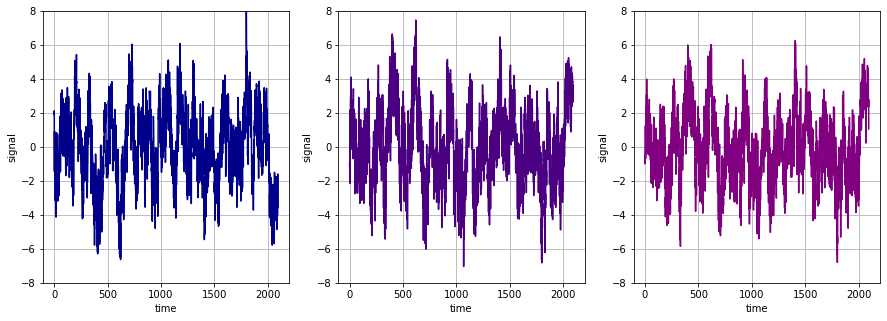

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(signal1, c='darkblue')
axs[1].plot(signal2, c='indigo')
axs[2].plot(signal3, c='purple')

for ax in axs:
    ax.set_xlabel('time')
    ax.set_ylabel('signal')
    ax.grid(True)
    ax.set_ylim(-8,8)
plt.show()

$$ \rho_{jk} = \frac{1}{\sigma_j \sigma_k} \left< (x_n^j - \left< x_n^j \right>)(x_{n+l}^k - \left< x_n^k \right>) \right> $$

where 
* $x_n^j$ is the j'th component of vctor $\mathbf x_n$
* $\sigma_j = \sqrt{ \left< \left(x_n^j- \left< x_n^j\right>\right)^2\right>}$

In [4]:
N = len(signal1)
data = np.loadtxt('data/data45.txt').T
data.shape

(3, 2096)

## Autocorrelation

In [5]:
def get_autocorrelation_coeff(data1, data2, N, l):
        
    mean1 = data1.mean()
    mean2 = data2.mean()
    
    sigma1 = data1.std()
    sigma2 = data2.std()
        
    denominator = (N-l) * sigma1 * sigma2
    
    nominator = 0
    
    for n in range(N-l):
        nominator+= (data1[n]- mean1)*(data2[n+l]-mean2)
        
    return nominator/denominator

In [6]:
def get_autocorrelation_matrix(data,N,l):
    
    dim = 3
    autocorr_matrix = np.zeros((dim, dim))
    
    for j in range(dim):
        for k in range(dim):
            autocorr_matrix[j][k] = get_autocorrelation_coeff( data[j], data[k],N,l)      
        
    return autocorr_matrix

In [7]:
def display(r):
    for row in r:
        str_r = [str( round(i, 3)) for i in row]
        print("\t".join(str_r))

In [8]:
def show(r):
    corr_matrix = pd.DataFrame(r)
    plt.figure(figsize=(5,5))
    plt.imshow(corr_matrix, cmap = newcmp, vmax = 1, vmin = -1)
    plt.colorbar()
    plt.show()
    

0.789	-0.846	-0.773
-0.849	0.657	0.837
-0.764	0.834	0.713


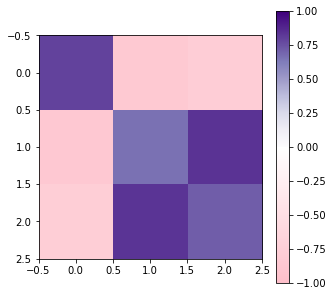

In [9]:
r1 = get_autocorrelation_matrix(data,N,l=1)
display(r1)
show(r1)

0.8	-0.733	-0.775
-0.736	0.802	0.704
-0.771	0.696	0.757


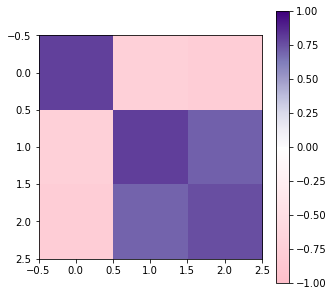

In [10]:
r2 = get_autocorrelation_matrix(data,N,l=2)
display(r2)
show(r2)

0.744	-0.744	-0.724
-0.748	0.68	0.735
-0.723	0.727	0.684


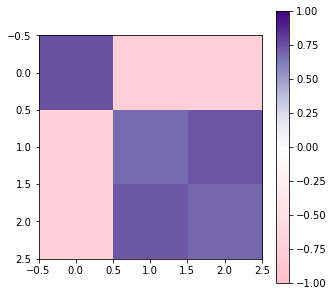

In [11]:
r3 = get_autocorrelation_matrix(data,N,l=3)
display(r3)
show(r3)

1.0	-0.72	-0.775
-0.72	1.0	0.696
-0.775	0.696	1.0


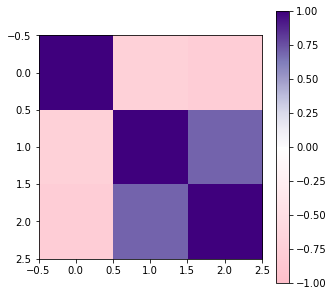

In [12]:
r0 = get_autocorrelation_matrix(data,N,l=0)
display(r0)
show(r0)

## Pearson coefficient

1.0	-0.72	-0.775
-0.72	1.0	0.696
-0.775	0.696	1.0


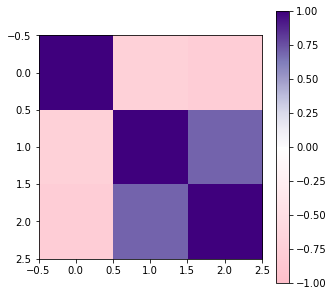

In [13]:
pearson_coeff = np.corrcoef(data)
display(pearson_coeff)
show(pearson_coeff)

# Fitting Three-dimensional VAR(1) model to the data.

In [14]:
def dividing_data_into_subseries_II(data, k=1):
    X = []
    Y = []
    data = data.T
    N = len(data)-k
    for i in range(N):
        tmp = []
        for j in range(k):
            tmp.append(data[j+i])
        X.append(tmp)
        Y.append(data[k+i] )
    return np.array(X).reshape(N,3), np.array(Y)

In [15]:
X, Y = dividing_data_into_subseries_II(data, k=1)
reg = LinearRegression(fit_intercept = False).fit(X, Y)
A = reg.coef_
print("model parameters: \n{:}".format(A))

model parameters: 
[[ 0.25768277 -0.52031278 -0.21534494]
 [-0.51995189 -0.0303738   0.50461486]
 [-0.27381808  0.50501923  0.09406492]]


## Check, how bad  are coefficients obtain from above fitting

In [16]:
def get_gamma_l(data, N, l):
    data= data.T
    gamma_l = np.zeros((3,3))
    for n in range(N-l):
        gamma_l += np.outer(data[n],data[n+l])
        
    return gamma_l/(N-l)

In [17]:
gamma0 = get_gamma_l(data, N, 0)
gamma1 = get_gamma_l(data, N, 1)
gamma2 = get_gamma_l(data, N, 2)
gamma3 = get_gamma_l(data, N, 3)
gamma4 = get_gamma_l(data, N, 4)

In [18]:
display(gamma1)
display(A @ gamma0)

3.912	-4.243	-3.51
-4.259	3.337	3.851
-3.47	3.837	2.972
3.915	-4.262	-3.469
-4.244	3.339	3.836
-3.512	3.854	2.972


In [19]:
display(gamma2)
print("\n\n")
display(A @ gamma1)

3.962	-3.674	-3.521
-3.69	4.071	3.24
-3.502	3.203	3.154



3.971	-3.656	-3.548
-3.656	4.041	3.208
-3.548	3.208	3.186


In [20]:
display(gamma3)
print("\n\n")

display(A @ gamma2)


3.685	-3.731	-3.291
-3.75	3.45	3.38
-3.283	3.343	2.848



3.695	-3.755	-3.272
-3.715	3.403	3.324
-3.278	3.363	2.897


In [21]:
display(gamma4)
print("\n\n")
display(A @ gamma3)

3.623	-3.502	-3.207
-3.482	3.596	3.09
-3.175	3.03	2.852



3.608	-3.477	-3.22
-3.458	3.522	3.046
-3.212	3.079	2.876


# Fitting Three-dimensional VAR(1) model based on linear regression for $\Gamma(l)$

In [22]:
X_tab=[]
Y_tab=[]

for l in range(0, 200):
    X_tab.append( get_gamma_l(data, N, l).flatten())
    Y_tab.append( get_gamma_l(data, N, l+1).flatten())

In [23]:
X = np.array(X_tab)
X.shape

(200, 9)

In [24]:
Y = np.array(Y_tab)
Y.shape

(200, 9)

(9, 9)

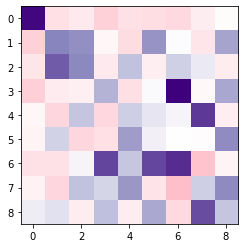

In [25]:
reg = LinearRegression(fit_intercept = False).fit(X, Y)
R = reg.coef_
plt.imshow(R, cmap = newcmp)
R.shape

Above matrix should have a form:

$$\begin{bmatrix}
A_{1,1} & 0 & 0 & A_{1,2} & 0 & 0 & A_{1,3} & 0 & 0 \\
0 & A_{1,1} & 0 & 0 & A_{1,2} & 0 & 0 & A_{1,3} & 0 \\
0 & 0 & A_{1,1} & 0 & 0 & A_{1,2} & 0 & 0 & A_{1,3} \\
A_{2,1} & 0 & 0 & A_{2,2} & 0 & 0 & A_{2,3} & 0 & 0 \\
0 & A_{2,1} & 0 & 0 & A_{2,2} & 0 & 0 & A_{2,3} & 0 \\
0 & 0 & A_{2,1} & 0 & 0 & A_{2,2} & 0 & 0 & A_{2,3} \\
A_{3,1} & 0 & 0 & A_{3,2} & 0 & 0 & A_{3,3} & 0 & 0 \\
0 & A_{3,1} & 0 & 0 & A_{3,2} & 0 & 0 & A_{3,3} & 0 \\
0 & 0 & A_{3,1} & 0 & 0 & A_{3,2} & 0 & 0 & A_{3,3} \\
\end{bmatrix} $$

In [26]:
A_matrix = np.zeros((3,3))

A_matrix[0][0] = ( R[0][0]+R[1][1]+R[2][2])/3
A_matrix[0][1] = ( R[0][3]+R[1][4]+R[2][5])/3
A_matrix[0][2] = ( R[0][6]+R[1][7]+R[2][8])/3

A_matrix[1][0] = ( R[3][0]+R[4][1]+R[5][2])/3
A_matrix[1][1] = ( R[3][3]+R[4][4]+R[5][5])/3
A_matrix[1][2] = ( R[3][6]+R[4][7]+R[5][8])/3

A_matrix[2][0] = ( R[6][0]+R[7][1]+R[8][2])/3
A_matrix[2][1] = ( R[6][3]+R[7][4]+R[8][5])/3
A_matrix[2][2] = ( R[6][6]+R[7][7]+R[8][8])/3

In [27]:
gamma0 = get_gamma_l(data, N, 0)
gamma1 = get_gamma_l(data, N, 1)
gamma2 = get_gamma_l(data, N, 2)
gamma3 = get_gamma_l(data, N, 3)
gamma4 = get_gamma_l(data, N, 4)

In [28]:
display(gamma1)
print("\n\n")
display(A_matrix @ gamma0)

3.912	-4.243	-3.51
-4.259	3.337	3.851
-3.47	3.837	2.972



3.799	-3.628	-3.29
-3.891	3.442	3.562
-3.356	3.374	3.022


In [29]:
display(gamma2)
print("\n\n")
display(A_matrix @ gamma1)

3.962	-3.674	-3.521
-3.69	4.071	3.24
-3.502	3.203	3.154



3.573	-3.524	-3.18
-3.559	3.715	3.137
-3.269	3.167	2.905


In [30]:
display(gamma3)
print("\n\n")
display(A_matrix @ gamma2)

3.685	-3.731	-3.291
-3.75	3.45	3.38
-3.283	3.343	2.848



3.436	-3.363	-3.053
-3.514	3.329	3.135
-3.114	3.078	2.767


In [31]:
display(gamma4)
print("\n\n")
display(A_matrix @ gamma3)

3.623	-3.502	-3.207
-3.482	3.596	3.09
-3.175	3.03	2.852



3.294	-3.24	-2.93
-3.323	3.325	2.936
-3.002	2.937	2.669


#  Assess the covariance matrix of the noise from gamma:

### results form fitting A directly into data $\mathbf{x}_n = \mathbf{A} \mathbf{x}_{n-1}$

In [32]:
display(A)


0.258	-0.52	-0.215
-0.52	-0.03	0.505
-0.274	0.505	0.094


In [33]:
noise = gamma0 - A@ gamma0 @ A.T
display(noise)

0.982	0.044	0.029
0.044	1.036	-0.009
0.029	-0.009	0.978


In [34]:
noise = gamma0 - A @ gamma1.T
display(noise)

0.984	0.05	0.009
0.064	1.021	0.012
0.022	-0.014	0.999


### results form fitting A on $\Gamma(l)$:  $$\mathbf{\Gamma(l)} = \mathbf{A} \mathbf{\Gamma(l-1)}$$

In [35]:
display(A_matrix)


0.382	-0.288	-0.245
-0.382	0.137	0.427
-0.263	0.311	0.265


In [36]:
noise = gamma0 - A_matrix @ gamma0 @ A_matrix.T
display(noise)

1.651	-0.26	-0.526
-0.26	1.599	0.165
-0.526	0.165	1.436


In [37]:
noise = gamma0 - A_matrix @ gamma1.T
display(noise)

1.377	-0.079	-0.361
-0.038	1.35	0.08
-0.247	0.025	1.276
